In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Django', 'PnP PowerShell']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"The Mines of the Behemoth, Shea",455.315722,9.292158,26.533660,49
Exchange Online and Defender,586.559570,15.039989,26.467136,39
Docker,588.039711,18.969023,36.507150,31
SSH + SCP,631.772992,21.785276,36.691930,29
GUI Docker Container,679.377534,32.351311,48.981171,21
Linux,1119.628519,34.988391,53.550680,32
"Everything is Tuberculosis, Green",830.821979,36.122695,58.730244,23
WinHex,840.757004,40.036048,55.845317,21
"The Simulacra, Dick",1028.689061,54.141530,74.189992,19
Windows PATH Variable,1719.128734,57.304291,115.600231,30


# Histogram

sum of ages: ~54977.71


<Axes: >

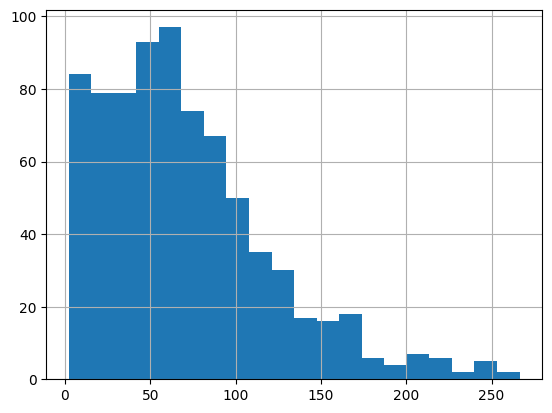

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54977.71


<Axes: >

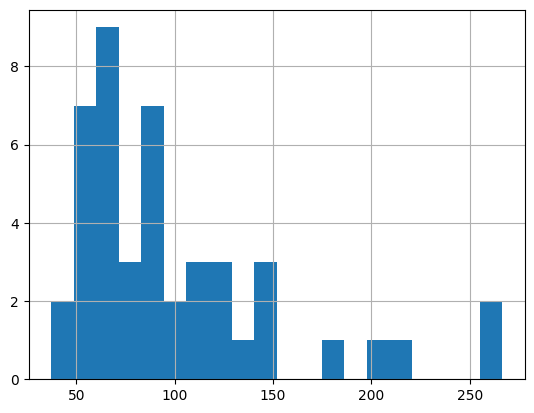

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Microsoft Purview']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [23]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [24]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [25]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [26]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

modulo for n-fold
Cards found: 771
Total card age: 54977.71


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
22,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,121.191003,121.191003,-121.191003,121.191003,0.110644,1,0,0,-121.191003
83,Accounting,Amortization\nSystematic allocation of the cos...,414cb89a0e514694fbe4916816272b11,248.209868,94.114976,-248.209868,752.919806,0.703020,8,0,0,-248.209868
607,Accounting,Contra-Asset Account\nAn account that offsets ...,e4e93a8a437c23e63933092562ca3175,85.515731,94.114976,-248.209868,752.919806,0.703020,8,3,0,-85.515731
85,Accounting,Intangible Assets\nNon-physical assets with va...,504f63116cc102434702ded20fae46df,55.737894,94.114976,-248.209868,752.919806,0.703020,8,6,0,-55.737894
79,TSQL,Window Functions:\n\nFunctions like ROW_NUMBER...,ed774e26f7161223f8f195315fce87c3,224.834971,97.379414,-224.834971,1168.552972,0.214557,12,0,0,-224.834971
80,TSQL,Q: What happens in T-SQL if you use GROUP BY b...,c3ed24d78b8a70215c7595f33fe32bc7,120.814097,97.379414,-224.834971,1168.552972,0.214557,12,3,0,-120.814097
81,TSQL,Self-Joins for Hierarchies:\n\nUseful for comp...,ead33c6a0051c6b6229a06a68ac14f06,76.229061,97.379414,-224.834971,1168.552972,0.214557,12,6,0,-76.229061
82,TSQL,Q: When should you use window functions instea...,8cad1f805f2826f36ec3874d70c61aff,52.972174,97.379414,-224.834971,1168.552972,0.214557,12,9,0,-52.972174
258,Power BI,Q: Why is a 200 K-row table (40 MB PBIX) unlik...,0af08bf57f17ab4ea91bf8941cafd0a9,222.010616,119.646054,-222.010616,1435.752650,0.508382,12,0,0,-222.010616
519,Power BI,Why might SUMMARIZECOLUMNS yield better perfor...,46e7b55df538b828c02c3231354001bc,160.101767,119.646054,-222.010616,1435.752650,0.508382,12,3,0,-160.101767



## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(1367.6171817926966)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
64,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,266.431171,99.226868,-266.431171,4465.209081,0.977249,45,0,0,-266.431171
330,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,258.437865,99.226868,-266.431171,4465.209081,0.977249,45,1,1,-258.437865
23,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,252.102816,112.060632,-252.102816,4034.182752,0.484949,36,0,0,-252.102816
289,Terraform Codebox,corepack pnpm test\nA command pattern used to ...,85012d4ed6b5e32d36886a085cc48197,251.531548,112.060632,-252.102816,4034.182752,0.484949,36,1,1,-251.531548
83,Accounting,Amortization\nSystematic allocation of the cos...,414cb89a0e514694fbe4916816272b11,248.209868,94.114976,-248.209868,752.919806,0.703020,8,0,0,-248.209868
15,Python + Oauth2.0,authorize_url\n\nThe endpoint where the user i...,6a264f45c613880c60d7986e3d683448,244.895313,114.872123,-244.895313,2182.570340,0.367802,19,0,0,-244.895313
98,"Mexican Gothic, Moreno-Garcia",traceries (TRAY-suh-reez)\nnoun\nDelicate orna...,3720f358b6a22134861965f53caa4c3e,244.819046,87.696592,-244.819046,2455.504566,0.840730,28,0,0,-244.819046
283,Python + Oauth2.0,"(""localhost"", 8080)\n\nThe address tuple passe...",d33808d12096e5298b1e5c8617c745a4,239.156895,114.872123,-244.895313,2182.570340,0.367802,19,1,1,-239.156895
264,CCH Tax Forms Project,Disabling GenerateMeta in CCH Axcess export op...,0881e21379d3a9f0ad63b7c4f20a58f9,229.458191,104.759406,-229.458191,1780.909898,0.369408,17,0,0,-229.458191
543,Python + Oauth2.0,handler.end_headers()\n\nFinalizes the HTTP re...,91ad05cd6046d3375013aa16d642650d,225.940254,114.872123,-244.895313,2182.570340,0.367802,19,2,2,-225.940254


In [30]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 71.307'